<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/nice_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [3]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,)
        #x = (x - torch.mean(x, axis=0).reshape(1, -1)) / (torch.std(x, axis=0).reshape(1, -1) + 0.00001)

        return self.f(x)

    def coupling_layer(self, x, m, forward=True):

        x_a = x[:, : x.shape[1]//2].reshape((len(x), -1,))
        x_b = x[:, x.shape[1]//2 :].reshape((len(x), -1, ))

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        z = torch.concat((x_a, y_b), axis=1)

        return z


    def f(self, x):
        z = x

        for model in self.m:
            z = self.coupling_layer(z, model, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(self.s)      # eksi olabilir başında

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for model in reversed(self.m):
            x = self.coupling_layer(x, model, forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) - log_det_j).sum()
        else:

            loss = - (prior.log_prob(z).sum(dim=1) - log_det_j).mean()
        return loss

In [4]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

train_data = Data(train_image)
test_data = Data(test_image)

100%|██████████| 9912422/9912422 [00:00<00:00, 162910398.83it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 134445831.10it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64229314.11it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14302198.77it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



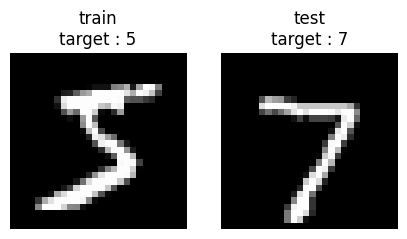

In [5]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [6]:
data_dim = 28*28
prior = torch.distributions.Normal(loc=torch.zeros((data_dim)), scale=torch.ones((data_dim)))

model = NICE(input_dim=data_dim, hidden_layer=64, num_flows=5)

train_loader = DataLoader(train_data, batch_size=30000)

In [7]:
epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%10 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  83351579.4375
Epoch :  10   -----------> Loss :  519684.90625
Epoch :  20   -----------> Loss :  341229.3125
Epoch :  30   -----------> Loss :  284896.125
Epoch :  40   -----------> Loss :  252847.3515625
Epoch :  50   -----------> Loss :  230659.6953125
Epoch :  60   -----------> Loss :  215070.7421875
Epoch :  70   -----------> Loss :  202887.5546875
Epoch :  80   -----------> Loss :  192711.375
Epoch :  90   -----------> Loss :  183780.3203125
Epoch :  100   -----------> Loss :  175857.453125
Epoch :  110   -----------> Loss :  168537.8125
Epoch :  120   -----------> Loss :  161654.1796875
Epoch :  130   -----------> Loss :  155472.0
Epoch :  140   -----------> Loss :  149588.9140625
Epoch :  150   -----------> Loss :  143454.890625
Epoch :  160   -----------> Loss :  138451.125
Epoch :  170   -----------> Loss :  132100.6796875
Epoch :  180   -----------> Loss :  128439.58203125
Epoch :  190   -----------> Loss :  122110.8359375
Epoch :  200   ----

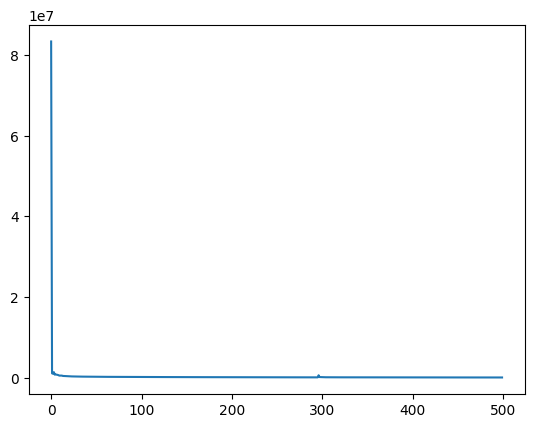

In [8]:
plt.plot(COST)

In [9]:
test = prior.sample((50,))
test

tensor([[ 0.6077,  0.8858,  1.2036,  ..., -1.5062,  0.9240,  0.8399],
        [-0.4879, -1.2420, -0.8708,  ...,  2.3522, -1.2461,  0.4959],
        [-0.1457,  0.3488, -0.3792,  ..., -0.6915, -0.7831, -0.4634],
        ...,
        [ 0.5431, -0.4176,  0.5603,  ..., -0.5961, -0.1892, -0.7135],
        [-1.6699, -0.6298, -0.5674,  ..., -0.7411,  0.3892,  0.4616],
        [ 0.4226,  0.1085,  1.0010,  ..., -0.3917,  0.0262, -1.1329]])

In [10]:
sonuc = model.f_inv(test)
sonuc[0].shape

torch.Size([784])

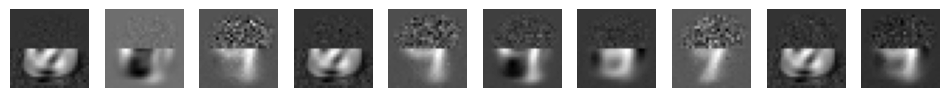

In [15]:
plt.figure(figsize=(12, 12))

for i in range(1, 11):
    plt.subplot(1,10,i)
    plt.imshow(sonuc[(i-1)*4].detach().numpy().reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.show()